In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [36]:
train_file_path = '../Data/train.csv'
test_file_path = '../Data/test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

y = train_data.Survived
X = train_data.drop(['Survived', 'PassengerId'], axis=1)

X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [39]:
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]

X[cols_with_missing].isnull().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

1) Drop Cabin Column for High amount of Missing Values
2) Drop Embarked column, since it may be unrelated
3) Impute Age column

Age Data: Median 28.0 Mean: 29.69911764705882 Std Dev: 14.526497332334042 Mode: 24.0


<Axes: >

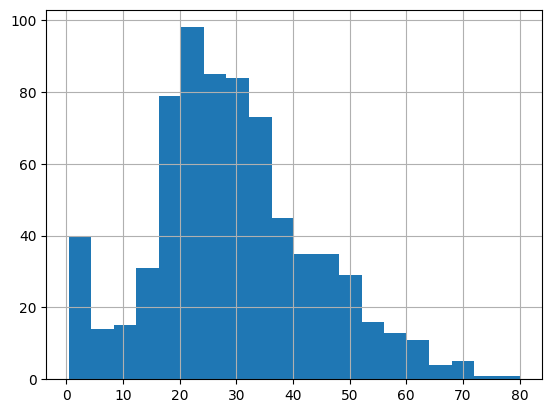

In [40]:
print("Age Data: Median", X['Age'].median(), "Mean:", X['Age'].mean(), "Std Dev:", X['Age'].std(), "Mode:", X['Age'].mode()[0])
X['Age'].hist(bins=20)

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.drop(['Embarked', 'Name'], axis=1)
X_valid = X_valid.drop(['Embarked', 'Name'], axis=1)


imputer = SimpleImputer(strategy='median')

numeric_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

all_cols = numeric_cols + categorical_cols

OH_preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputer, numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

OE_preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputer, numeric_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ])

OH_XGB_model = Pipeline(steps=[
    ('preprocessor', OH_preprocessor),
    ('model', XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0))
])

OE_XGB_model = Pipeline(steps=[
    ('preprocessor', OE_preprocessor),
    ('model', XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0))
])

In [42]:
estimators = [50, 100, 200, 500, 1000]
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.2]

def OH_model_performance(n_est, lr):
    OH_XGB_model.set_params(model__n_estimators=n_est, model__learning_rate=lr)
    OH_XGB_model.fit(X_train, y_train)
    preds = OH_XGB_model.predict(X_valid)
    
    preds = (preds > 0.5).astype(int)
    
    acc = accuracy_score(preds, y_valid)
    return acc

def OE_model_performance(n_est, lr):
    OE_XGB_model.set_params(model__n_estimators=n_est, model__learning_rate=lr)
    OE_XGB_model.fit(X_train, y_train)
    preds = OE_XGB_model.predict(X_valid)
    
    preds = (preds > 0.5).astype(int)
    
    acc = accuracy_score(preds, y_valid)
    return acc

In [43]:
for est in estimators:
    for lr in learning_rates:
        print("[", est, ", ", lr, "]: ", OH_model_performance(n_est=est, lr=lr))

[ 50 ,  0.005 ]:  0.8268156424581006
[ 50 ,  0.01 ]:  0.8268156424581006
[ 50 ,  0.05 ]:  0.8547486033519553
[ 50 ,  0.1 ]:  0.8547486033519553
[ 50 ,  0.2 ]:  0.8547486033519553
[ 100 ,  0.005 ]:  0.8268156424581006
[ 100 ,  0.01 ]:  0.8491620111731844
[ 100 ,  0.05 ]:  0.8547486033519553
[ 100 ,  0.1 ]:  0.8603351955307262
[ 100 ,  0.2 ]:  0.8547486033519553
[ 200 ,  0.005 ]:  0.8491620111731844
[ 200 ,  0.01 ]:  0.8547486033519553
[ 200 ,  0.05 ]:  0.8603351955307262
[ 200 ,  0.1 ]:  0.8659217877094972
[ 200 ,  0.2 ]:  0.8603351955307262
[ 500 ,  0.005 ]:  0.8491620111731844
[ 500 ,  0.01 ]:  0.8547486033519553
[ 500 ,  0.05 ]:  0.8603351955307262
[ 500 ,  0.1 ]:  0.8603351955307262
[ 500 ,  0.2 ]:  0.8603351955307262
[ 1000 ,  0.005 ]:  0.8491620111731844
[ 1000 ,  0.01 ]:  0.8547486033519553
[ 1000 ,  0.05 ]:  0.8603351955307262
[ 1000 ,  0.1 ]:  0.8603351955307262
[ 1000 ,  0.2 ]:  0.8603351955307262


In [44]:
for est in estimators:
    for lr in learning_rates:
        print("[", est, ", ", lr, "]: ", OE_model_performance(n_est=est, lr=lr))

[ 50 ,  0.005 ]:  0.7821229050279329
[ 50 ,  0.01 ]:  0.7150837988826816
[ 50 ,  0.05 ]:  0.441340782122905
[ 50 ,  0.1 ]:  0.4860335195530726
[ 50 ,  0.2 ]:  0.44692737430167595
[ 100 ,  0.005 ]:  0.7150837988826816
[ 100 ,  0.01 ]:  0.6480446927374302
[ 100 ,  0.05 ]:  0.43575418994413406
[ 100 ,  0.1 ]:  0.46368715083798884
[ 100 ,  0.2 ]:  0.4692737430167598
[ 200 ,  0.005 ]:  0.6759776536312849
[ 200 ,  0.01 ]:  0.4860335195530726
[ 200 ,  0.05 ]:  0.441340782122905
[ 200 ,  0.1 ]:  0.46368715083798884
[ 200 ,  0.2 ]:  0.4860335195530726
[ 500 ,  0.005 ]:  0.4748603351955307
[ 500 ,  0.01 ]:  0.43575418994413406
[ 500 ,  0.05 ]:  0.44692737430167595
[ 500 ,  0.1 ]:  0.4748603351955307
[ 500 ,  0.2 ]:  0.49162011173184356
[ 1000 ,  0.005 ]:  0.44692737430167595
[ 1000 ,  0.01 ]:  0.44692737430167595
[ 1000 ,  0.05 ]:  0.45251396648044695
[ 1000 ,  0.1 ]:  0.4860335195530726
[ 1000 ,  0.2 ]:  0.49162011173184356


#### Optimum Parameters: One-Hot Encoding, (n_estimators, learning_rate) = (200, 0.1)

In [45]:
OH_XGB_model.set_params(model__n_estimators=200, model__learning_rate=0.1)
OH_XGB_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
submission_preds = OH_XGB_model.predict(test_data[all_cols])
submission_preds = (submission_preds > 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived': submission_preds
})

submission.to_csv('3rd_submission.csv', index=False)
